# 2D Preprocessing the GlobColour Dataset 
* prepare dataset for LDS-fitting:
   * load all 5 variables and merge (interpolate) with the float dataset
   * load the distance to coast and merge (interpolate) with the float dataset
   * output the data on disk
   * (plan)if needed, split Nov-Dec, encoding the weekly number

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
from dask.diagnostics import ProgressBar
import seaborn as sns
from matplotlib.colors import LogNorm

In [2]:
# resampling frequency in number of days
freq=2

In [3]:
from tools.load_GlobColor_dataset import load_dataset
import importlib
importlib.reload(load_dataset)

<module 'tools.load_GlobColor_dataset.load_dataset' from '/Users/vyan2000/work_linux/2Archive/myproject/20161024xray_oceancolor/ocean_color-master/tools/load_GlobColor_dataset/load_dataset.py'>

100%|██████████| 5538/5538 [01:12<00:00, 76.57it/s]


<xarray.Dataset>
Dimensions:    (lat: 553, lon: 721, time: 5538)
Coordinates:
  * lat        (lat) float32 28.0208 27.9792 27.9375 27.8958 27.8542 27.8125 ...
  * lon        (lon) float32 44.9792 45.0208 45.0625 45.1042 45.1458 45.1875 ...
  * time       (time) datetime64[ns] 2002-04-28 2002-04-29 2002-04-30 ...
Data variables:
    CHL1_mean  (time, lat, lon) float64 nan nan nan nan nan nan nan nan nan ...
Attributes:
    Conventions:                CF-1.4
    title:                      GlobColour daily merged MERIS/SeaWiFS product
    product_name:               L3m_20020428__665648402_4_AVW-MERSWF_CHL1_DAY...
    product_type:               day
    product_version:            2016.1
    product_level:              3
    parameter_code:             CHL1
    parameter:                  Chlorophyll concentration
    parameter_algo_list:        ,
    publication:                O'Reilly, J.E., and 24 Coauthors, 2000: SeaWi...
    site_name:                  665648402
    sensor_name:   

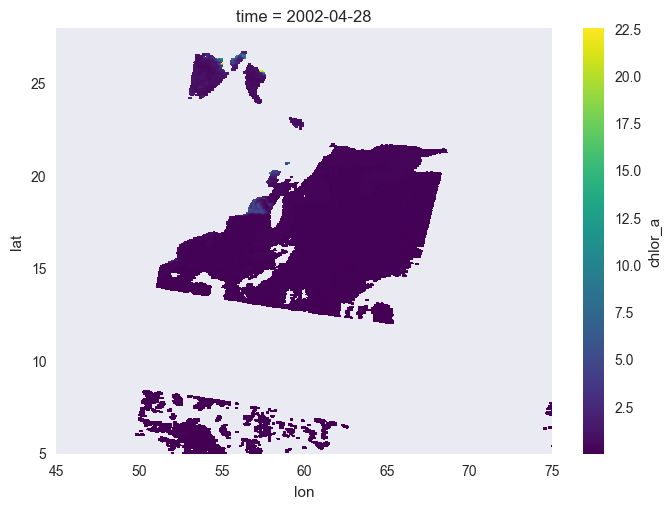

In [4]:
############### CHL1
ds_daily = load_dataset.load_chl1()
ds_daily.chlor_a.sel(time='2002-04-28').plot()

In [6]:
freq_resample = str(8) + 'D'
ds_8day = ds_daily.resample(freq_resample, dim='time')  # see the above for doc, test case, & default behavior
ds_8day

<xarray.Dataset>
Dimensions:  (lat: 553, lon: 721, time: 695)
Coordinates:
  * lat      (lat) float32 28.0208 27.9792 27.9375 27.8958 27.8542 27.8125 ...
  * lon      (lon) float32 44.9792 45.0208 45.0625 45.1042 45.1458 45.1875 ...
  * time     (time) datetime64[ns] 2002-04-28 2002-05-06 2002-05-14 ...
Data variables:
    chlor_a  (time, lat, lon) float64 nan nan nan nan nan nan nan nan nan ...

In [7]:
# check data quality
both_datasets = [ds_8day, ds_daily]
print([(ds.nbytes / 1e6) for ds in both_datasets])

[2216.854936, 17664.630152]


In [8]:
def fix_bad_data(ds):
    # for some reason, the cloud / land mask is backwards on some data
    # this is obvious because there are chlorophyl values less than zero
    bad_data = ds.chlor_a.groupby('time').min() < 0
    # loop through and fix
    for n in np.nonzero(bad_data.values)[0]:
        data = ds.chlor_a[n].values 
        ds.chlor_a.values[n] = np.ma.masked_less(data, 0).filled(np.nan)

In [9]:
[fix_bad_data(ds) for ds in both_datasets]

[None, None]

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in greater
  if not reflexive


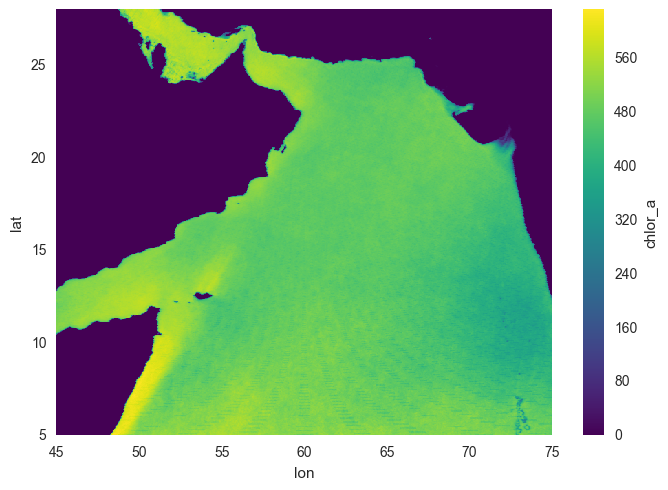

In [10]:
# Count the number of ocean data points
(ds_8day.chlor_a>0).sum(dim='time').plot()

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in greater
  if not reflexive


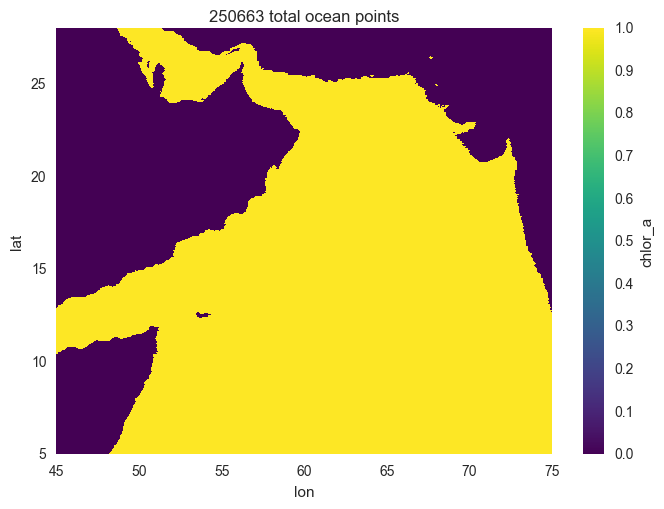

In [11]:
#  find a mask for the land
ocean_mask = (ds_8day.chlor_a>0).sum(dim='time')>0
num_ocean_points = ocean_mask.sum().values
ocean_mask.plot()
plt.title('%g total ocean points' % num_ocean_points)

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/colors.py:1022: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


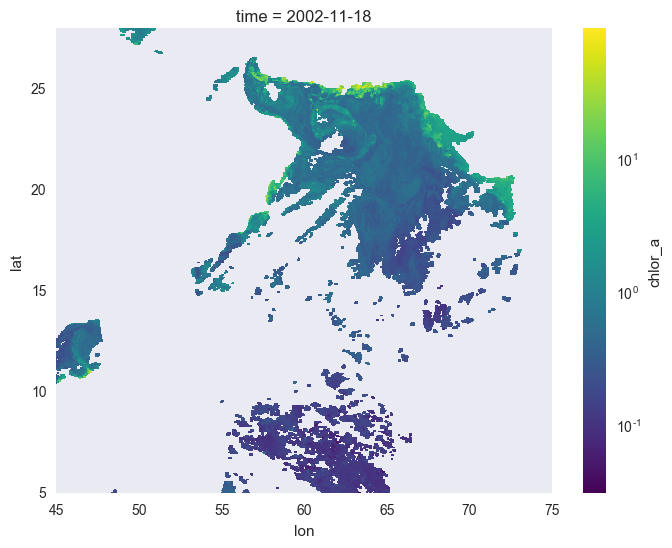

In [12]:
plt.figure(figsize=(8,6))
ds_daily.chlor_a.sel(time='2002-11-18',method='nearest').plot(norm=LogNorm())

In [13]:
ds_daily.groupby('time').count() # information from original data

<xarray.Dataset>
Dimensions:  (time: 5538)
Coordinates:
  * time     (time) datetime64[ns] 2002-04-28 2002-04-29 2002-04-30 ...
Data variables:
    chlor_a  (time) int64 62260 52391 58822 43103 37195 55773 25428 19652 ...

In [14]:
ds_daily.chlor_a.groupby('time').count()/float(num_ocean_points)

<xarray.DataArray 'chlor_a' (time: 5538)>
array([ 0.248381,  0.20901 ,  0.234666, ...,  0.003495,  0.020705,  0.034552])
Coordinates:
  * time     (time) datetime64[ns] 2002-04-28 2002-04-29 2002-04-30 ...

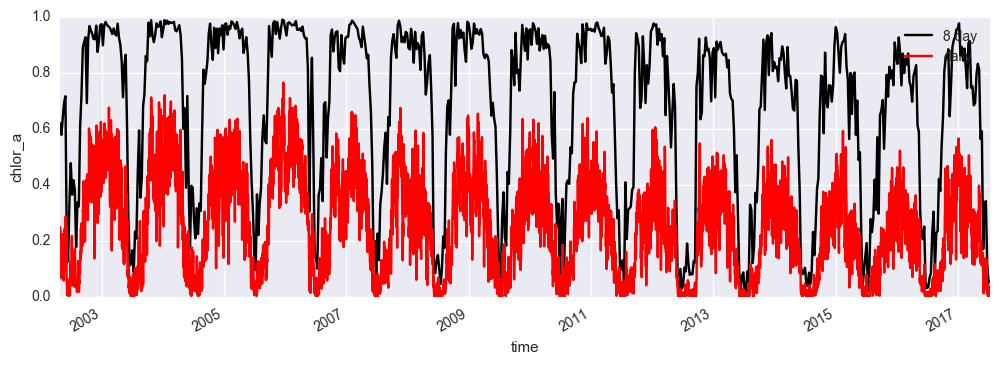

In [15]:
count_8day,count_daily = [ds.chlor_a.groupby('time').count()/float(num_ocean_points)
                            for ds in (ds_8day,ds_daily)]

plt.figure(figsize=(12,4))
count_8day.plot(color='k')
count_daily.plot(color='r')

plt.legend(['8 day','daily'])

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/colors.py:1022: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


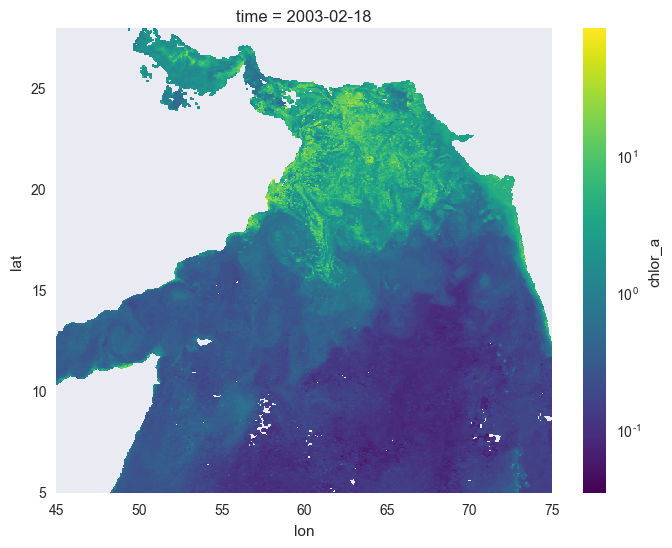

In [16]:
# Maps of individual days
target_date = '2003-02-15'
plt.figure(figsize=(8,6))
ds_8day.chlor_a.sel(time=target_date, method='nearest').plot(norm=LogNorm())

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/colors.py:1022: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


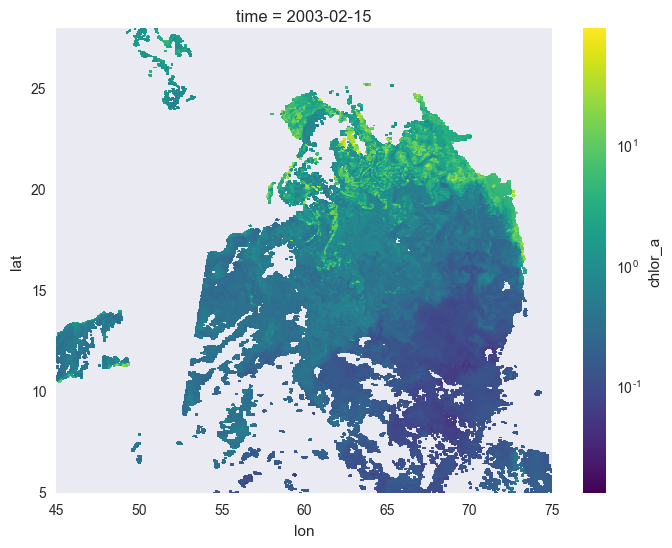

In [17]:
plt.figure(figsize=(8,6))
ds_daily.chlor_a.sel(time=target_date, method='nearest').plot(norm=LogNorm())

In [18]:
# next carry out interpolation starts here
freq_resample = str(freq) + 'D'
ds_resample = ds_daily.resample(freq_resample, dim='time')  # see the above for doc, test case, & default behavior
ds_resample

<xarray.Dataset>
Dimensions:  (lat: 553, lon: 721, time: 2777)
Coordinates:
  * lat      (lat) float32 28.0208 27.9792 27.9375 27.8958 27.8542 27.8125 ...
  * lon      (lon) float32 44.9792 45.0208 45.0625 45.1042 45.1458 45.1875 ...
  * time     (time) datetime64[ns] 2002-04-28 2002-04-30 2002-05-02 ...
Data variables:
    chlor_a  (time, lat, lon) float64 nan nan nan nan nan nan nan nan nan ...

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/colors.py:1022: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


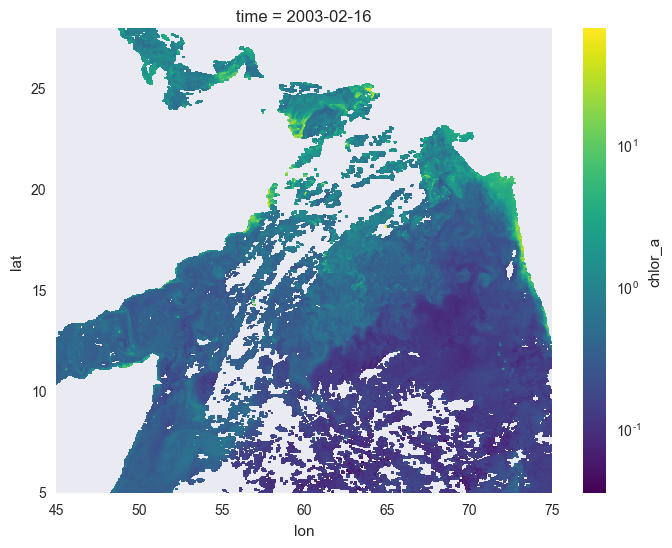

In [19]:
plt.figure(figsize=(8,6))
ds_resample.chlor_a.sel(time=target_date, method='nearest').plot(norm=LogNorm())

In [20]:
# check the range for the longitude
print(ds_resample.lon.min(),'\n' ,ds_resample.lat.min())  

<xarray.DataArray 'lon' ()>
array(44.97917175292969) 
 <xarray.DataArray 'lat' ()>
array(5.020830154418945)


# ++++++++++++++++++++++++++++++++++++++++++++++
# All GDP Floats
# Load the float data
# Map a (time, lon, lat) to a value on the cholorphlly value

In [ ]:
from buyodata import buoydata
import os

In [ ]:
fnamesAll = ['./gdp_float/buoydata_1_5000.dat','./gdp_float/buoydata_5001_10000.dat','./gdp_float/buoydata_10001_15000.dat','./gdp_float/buoydata_15001_jun16.dat']

In [ ]:
# read them and cancatenate them into one DataFrame
dfAll = pd.concat([buoydata.read_buoy_data(f) for f in fnamesAll])  # around 4~5 minutes

#mask = df.time>='2002-07-04' # we only have data after this data for PAR
dfvvAll = dfAll[dfAll.time>='2002-07-04']

sum(dfvvAll.time<'2002-07-04') # recheck whether the time is 

In [ ]:
# process the data so that the longitude are all >0
print('before processing, the minimum longitude is%f4.3 and maximum is %f4.3' % (dfvvAll.lon.min(), dfvvAll.lon.max()))
mask = dfvvAll.lon<0
dfvvAll.lon[mask] = dfvvAll.loc[mask].lon + 360
print('after processing, the minimum longitude is %f4.3 and maximum is %f4.3' % (dfvvAll.lon.min(),dfvvAll.lon.max()) )

dfvvAll.describe()

In [ ]:
# Select only the arabian sea region
arabian_sea = (dfvvAll.lon > 45) & (dfvvAll.lon< 75) & (dfvvAll.lat> 5) & (dfvvAll.lat <28)
# arabian_sea = {'lon': slice(45,75), 'lat': slice(5,28)} # later use this longitude and latitude
floatsAll = dfvvAll.loc[arabian_sea]   # directly use mask
print('dfvvAll.shape is %s, floatsAll.shape is %s' % (dfvvAll.shape, floatsAll.shape) )

In [ ]:
# pands dataframe cannot do the resamplingn properly
# cause we are really indexing on ['time','id'], pandas.dataframe.resample cannot do this
# TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'MultiIndex'


In [ ]:
# dump the surface floater data from pandas.dataframe to xarray.dataset
floatsDSAll = xr.Dataset.from_dataframe(floatsAll.set_index(['time','id']) ) # set time & id as the index); use reset_index to revert this operation
floatsDSAll

In [ ]:
print(floatsDSAll.dims)
# resample on the xarray.dataset onto two-day frequency
floatsDSAll_resample =floatsDSAll.resample(freq_resample, dim='time')
print(floatsDSAll_resample.dims)   # downsampling on the 'time' dimension 17499/9/4=  around 486
floatsDSAll_resample

In [ ]:
# transfer it back to pandas.dataframe for plotting
floatsDFAll_resample = floatsDSAll_resample.to_dataframe()
floatsDFAll_resample
floatsDFAll_resample = floatsDFAll_resample.reset_index()
floatsDFAll_resample
# visualize the subsamping of floats around arabian region
fig, ax  = plt.subplots(figsize=(12,10))
floatsDFAll_resample.plot(kind='scatter', x='lon', y='lat', c='temp', cmap='RdBu_r', edgecolor='none', ax=ax)

In [ ]:
print(floatsDFAll_resample_timeorder.lon.shape)
print(floatsDFAll_resample_timeorder.lon.dropna().shape )

############ interpolation starts from here
# to understand the float data better
# a: Look into the floatsDFAll_9Dtimeorder data in more details
# check the nan counts in each id
# plot the trajectory of {time, lat, lon, temperature,} for each float id,  
# this steps helps to understand the float dataset and if there is a need, improve it.

# b: take the float data as it is, and do the interpolation, whenever there is a nan value use the nearest neigbhours....
# check whether the quality of interpolataion is improved, if not, then have to fall back to to task 1

# c: vectorization

# DataFrame panel data 
# floatsDFAll_9Dtimeorder.set_index(['id','time']) 
# the inverse operation # floatsDFAll_9Dtimeorder.reset_index()
# look into the data
print(floatsDFAll_resample_timeorder[100:105])
# so far there is no need to convert it into a panel 
# floatsDFAll_9DtimeorderPanel = floatsDFAll_9Dtimeorder.to_panel

# plot the temperature for one float, the temperature do have a trend
#maskid = (floatsDFAll_resample_timeorder.id == 63069) & (floatsDFAll_resample_timeorder.time > '2007-01-01') & (floatsDFAll_resample_timeorder.time < '2009-01-01')
maskid = (floatsDFAll_resample_timeorder.id == 63069)
print(floatsDFAll_resample_timeorder[maskid].dropna(subset=['id', 'lat', 'lon', 'time']) )
floatsDFAll_resample_timeorder[maskid].dropna(subset=['id', 'lat', 'lon', 'time']).plot(x='time', y ='temp')

# set of all float ids
print(floatsDFAll_resample_timeorder.id.unique())

# this is a float that explains the need for temperature data
maskid2 = floatsDFAll_resample_timeorder.id == 10208
print(floatsDFAll_resample_timeorder[maskid2].head())


In [ ]:
################
# test case 1: take a single entry (southeast corner for valid values)
row_case1 =  pd.DataFrame(data = {'time':'2002-07-13 00:00:00', 'id': 10206, 'lon':74.7083358765, 'lat':5.20833349228},index=[1])
print(row_case1)

################
# test case 2
# take a {time-list, id-list, lon-list, lat-list}, index-list 
# carry out the interpolation
#row_case2 =  pd.DataFrame(data = {'time':['2002-07-13 00:00:00','2002-07-22 00:00:00'] , 'id': [10206, 10206], 'lon':[74.7083358765, 74.6250076294], 'lat':[5.20833349228, 5.29166173935]},index=[2,3])
#print(row_case2)
################
# test case 3
row_case2 =  pd.DataFrame(data = {'time':['2002-07-13 00:00:00', '2002-07-22 00:00:00', '2002-07-13 00:00:00'] , 'id': [10206, 10206, 10206], 'lon':[74.7083358765, 74.6250076294,74.7083358765], 'lat':[5.20833349228, 5.29166173935, 5.20833349228]},index=[1,2,3])
print(row_case2)



####
## get the indices of time, lat, lon
idx_time = ds_resample.indexes['time']
idx_lat = ds_resample.indexes['lat']
idx_lon = ds_resample.indexes['lon']

#### 
#interpolation on the time dimension
time_len = len(row_case2.time.values)
xtime_test = list([ np.datetime64(row_case2.time.values[i]) for i in range(0,time_len)  ] )  # for delta 
print('\n xtime_test \n', xtime_test)

'''caution: cannot do this inside the function get_loc,
see https://github.com/pandas-dev/pandas/issues/3488
'''
itime_nearest = [idx_time.get_loc(xtime_test[i], method='nearest') for i in range(0, time_len)]
print('\n itime_nearest \n', itime_nearest)  # [1,2]

xtime_nearest =  ds_resample.time[itime_nearest].values  #  ['2002-07-13T00:00:00.000000000' '2002-07-22T00:00:00.000000000']
print('\n xtime_nearest\n', xtime_nearest)  # ['2002-07-13T00:00:00.000000000' '2002-07-22T00:00:00.000000000']
print('xtime_nearest', type(xtime_nearest)) # xtime_nearest <class 'numpy.ndarray'> # time_nearest <class 'numpy.datetime64'>

# the time distance in days
delta_xtime = (xtime_test - xtime_nearest) / np.timedelta64(1, 'D')
print('\n delta_xtime in days \n', delta_xtime)
print(type(delta_xtime))

itime_next = [itime_nearest[i]+1 if  delta_xtime[i] >=0  else itime_nearest[i]-1  for i in range(0, time_len) ]
print('\n itime_next \n',itime_next)  # [2, 3]

# find the next coordinate values
xtime_next = ds_resample.time[itime_next].values
print('\n xtime_next \n', xtime_next) # ['2002-07-22T00:00:00.000000000' '2002-07-31T00:00:00.000000000']

# prepare for the Tri-linear interpolation
base_time = (xtime_next - xtime_nearest) / np.timedelta64(1, 'D')  # [ 9.  9.]
print('\n base_time \n', base_time)
w_time = delta_xtime / base_time  
print('\n w_time \n', w_time) # [ 0.  0.]


#### 
#interpolation on the lat dimension
xlat_test = row_case2.lat.values + 0.06   # base [ 5.20833349  5.29166174] # cell distance around .8, use .2 & .6 as two tests
print('\n xlat_test \n', xlat_test)       # xlat_test [ 5.26833349  5.35166174]

ilat_nearest = [idx_lat.get_loc(xlat_test[i], method='nearest') for i in range(0, time_len)]
print('\n ilat_nearest \n', ilat_nearest) # [272, 271]

xlat_nearest = ds_resample.lat[ilat_nearest].values  
print('\n xlat_nearest \n', xlat_nearest) # [ 5.29166174  5.37499762]

delta_xlat = xlat_test - xlat_nearest
print("\n delta_xlat \n",delta_xlat)      #  [-0.02332825 -0.02333588]


# the nearest index is on the right; but order of the latitude is different, it is descending
ilat_next = [ilat_nearest[i]-1 if  delta_xlat[i] >=0  else ilat_nearest[i]+1  for i in range(0, time_len) ]
print('\n ilat_next \n', ilat_next)  # [273, 272]

# find the next coordinates value
xlat_next = ds_resample.lat[ilat_next].values
print('\n xlat_next \n', xlat_next)  # [ 5.20833349  5.29166174]

# prepare for the Tri-linear interpolation
w_lat = delta_xlat / (xlat_next - xlat_nearest)
print('\n w_lat \n', w_lat) # [ 0.27995605  0.28002197]

#### 
#interpolation on the lon dimension
xlon_test = row_case2.lon.values +0.06 # base [74.7083358765, 74.6250076294] # cell distance around .8, use .2 & .6 as two tests
print('\n xlon_test \n', xlon_test)  # [ 74.76833588  74.68500763]

ilon_nearest = [idx_lon.get_loc(xlon_test[i], method='nearest') for i in range(0, time_len)]
print('\n ilon_nearest \n', ilon_nearest) # [357, 356]

xlon_nearest = ds_resample.lon[ilon_nearest].values  
print('\n xlon_nearest \n', xlon_nearest) # [ 74.79166412  74.70833588]

delta_xlon = xlon_test - xlon_nearest     
print("\n delta_xlon \n", delta_xlon)     #  [-0.02332825 -0.02332825]

ilon_next = [ilon_nearest[i]+1 if  delta_xlon[i] >=0  else ilon_nearest[i]-1  for i in range(0, time_len) ]
print('\n ilon_next \n',ilon_next)  # [356, 355]

# find the next coordinate values
xlon_next = ds_resample.lon[ilon_next].values
print("\n xlon_next \n", xlon_next) # [ 74.70833588  74.62500763]

# prepare for the Tri-linear interpolation
w_lon = delta_xlon / (xlon_next - xlon_nearest)
print("\n w_lon \n", w_lon) # [ 0.27995605  0.27995605]

####
# local Tensor product for Trilinear interpolation
# caution: nan values, store as "list_of_array to 2d_array" first, then sum

# no casting to list needed here, inputs are already lists
tmp = np.array([
         ds_resample.chlor_a.isel_points(time=itime_nearest, lat=ilat_nearest, lon=ilon_nearest).values,
         ds_resample.chlor_a.isel_points(time=itime_nearest, lat=ilat_nearest, lon=ilon_next).values,
         ds_resample.chlor_a.isel_points(time=itime_nearest, lat=ilat_next, lon=ilon_nearest).values,
         ds_resample.chlor_a.isel_points(time=itime_nearest, lat=ilat_next, lon=ilon_next).values,
         ds_resample.chlor_a.isel_points(time=itime_next, lat=ilat_nearest, lon=ilon_nearest).values,
         ds_resample.chlor_a.isel_points(time=itime_next, lat=ilat_nearest, lon=ilon_next).values,
         ds_resample.chlor_a.isel_points(time=itime_next, lat=ilat_next, lon=ilon_nearest).values,
         ds_resample.chlor_a.isel_points(time=itime_next, lat=ilat_next, lon=ilon_next).values ])

weights =  np.array([(1-w_time)*(1-w_lat)*(1-w_lon), 
                     (1-w_time)*(1-w_lat)*w_lon,
                     (1-w_time)*w_lat*(1-w_lon), 
                     (1-w_time)*w_lat*w_lon,
                        w_time*(1-w_lat)*(1-w_lon),
                        w_time*(1-w_lat)*w_lon,
                        w_time*w_lat*(1-w_lon),
                        w_time*w_lat*w_lon ])


# how to deal with "nan" values, fill in missing values for the np.array tmpAll 
# or fill the mean values to the unweighted array
# http://stackoverflow.com/questions/18689235/numpy-array-replace-nan-values-with-average-of-columns

print('\n neighbouring tensor used \n', tmp)
'''
 neighbouring tensor used 
 [[        nan  0.181841  ]
 [ 0.245878           nan]
 [        nan         nan]
 [        nan         nan]
 [ 0.19680101         nan]
 [        nan         nan]
 [        nan         nan]
 [ 0.18532801         nan]]
'''

# column min: (nan+0.245878 + nan + nan + 0.19680101 + nan +  nan + 0.18532801)/8 = 0.20933567333
col_mean = np.nanmean(tmp, axis=0)
print('\n its mean along axis 0(column) \n', col_mean)  #  [ 0.20933567  0.181841  ]


# filling the missing values.
inds = np.where(np.isnan(tmp))
print('\n nan index\n', inds)
tmp[inds]=np.take(col_mean, inds[1])
print('\n values after the fill \n', tmp)

print('\n weighting tensor used \n', weights)

print("weights.shape", weights.shape) # (8, 3)
print("tmp.shape", tmp.shape)  # (8, 3)

nrow_w, ncol_w = weights.shape
nrow_t, ncol_t = tmp.shape
assert nrow_w == nrow_t, "the row count of weights and values are not the same!"
assert ncol_w == ncol_t, "the row count of weights and values are not the same!"
print('\n tensor product\n', np.dot(weights[:,0], tmp[:,0]) ) # 0.216701896135 should be [ 0.2167019]

# new interpolation process of the Chl_a
chl_new = np.empty(ncol_w)
for i in range(0, ncol_w, 1):
    chl_new[i] =  np.dot(weights[:,i], tmp[:,i])

print('chl_newInt',  chl_new) #  [ 0.2167019  0.181841   0.2167019]
# validate by 1D array
# val = np.array([0.20933567, 0.245878,  0.20933567,
#                0.20933567, 0.19680101, 0.20933567,
#               0.20933567,0.18532801]) 
# np.dot(val, weights) # 0.21670189702309739


## output xarray.dataarray of points, see examples below
# this is the way how xarray.Dataset works
# if you want a xarray.DataArray, first generate a xarray.Dataset, then select DataArray from there.
chl_newInt = xr.Dataset({'chl': (['points'], np.random.randn(3))},
                        coords={
                                'time':(['points'],['2002-07-13 00:00:00', '2002-07-22 00:00:00', '2002-07-13 00:00:00']) , 
                                'id': (['points'], [10206, 10206, 10206]), 
                                'lon': (['points'], [74.7083358765, 74.6250076294,74.7083358765]),
                                'lat':(['points'], [5.20833349228, 5.29166173935, 5.20833349228]), 
                                'points': (['points'], [0,1,2])}) # this way the dims is set to point

print('\n',chl_newInt.chl)
'''
### Task: output xarray.dataarray as points
## example 1
arr = xr.DataArray(np.random.rand(4,3), [('time', pd.date_range('2000-01-01', periods=4)), ('space', ['IA', 'IL', 'IN'])] )
print("first example",arr)
print("\n \n")

## example2 -- concrete xr.DataArray
data = np.random.rand(4, 3)
locs = ['IA', 'IL', 'IN']
times = pd.date_range('2000-01-01', periods=4)
brr = xr.DataArray(data, coords={'time': times, 'space': locs, 'const': 42, \
                          'ranking': ('space', [1, 2, 3])}, \
             dims=['time', 'space'])
print("second example",brr)
'''

'''
### the target output
#the output generated by the xarray.DataSet => xarray.DataArray
<xarray.DataArray 'chlor_a' (points: 147112)>
array([ nan,  nan,  nan, ...,  nan,  nan,  nan])
Coordinates:
    time     (points) datetime64[ns] 2002-07-04 2002-07-04 2002-07-04 ...
    lon      (points) float64 74.96 66.54 69.88 65.04 69.88 74.96 69.46 ...
    lat      (points) float64 27.96 16.21 13.62 16.04 13.62 27.96 20.04 ...
  * points   (points) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  
### the solution approach we tried to is: first,  generate a xarray.DataSet
                                          second, generte a xarray.DataArray from the xarray DataSet if needed.
 
# 1. looking at this example, DataArray seems to be working.

# works here
da_test1 = xr.DataArray(np.random.rand(3), dims=['x'],
                        coords={'x': np.array([10206, 10206, 10206]), 'y':  2} )
print('\n da_test1', da_test1)

##########
# but not works here
da_test1 = xr.DataArray(np.random.rand(3), dims=['x'],
                        coords={'x': np.array([10206, 10206, 10206]), 'y':  np.array([10206, 10206, 10206])} )
print('\n da_test1', da_test1)

# err's
##########

##########
# works here
da_test1 = xr.DataArray(np.random.rand(3), dims=['x'],
                        coords={'x': np.array([10206, 10206, 10206]), 'y':  2} )
print('\n da_test1', da_test1)

# da_test1 <xarray.DataArray (x: 3)>
# array([ 0.90386212,  0.21516239,  0.44707272])
# Coordinates:
#   * x        (x) int64 10206 10206 10206
#     y        int64 2
##########

##########
# so we do this
# this is the way how xarray.Dataset works
# if you want a xarray.DataArray, first generate a xarray.Dataset, then select DataArray from there.
chl_newInt = xr.Dataset({'chl': (['id'], np.random.randn(3))},
                        coords={ 
                           'id':  (['id'], np.array([10206, 10206, 10206])), 
                           'lon': (['id'], np.array([74.7083358765, 74.6250076294,74.7083358765])), 
                           'lat': (['id'], np.array([5.20833349228, 5.29166173935, 5.20833349228]))})
print('chl_newInt', chl_newInt) # generate the xarray.DataSet
print('\n \n')
print('chl_newInt.chl', chl_newInt.chl) # xarray.DataSet contains many xarray.DataArray


#chl_newInt <xarray.Dataset>
#Dimensions:  (id: 3)
#Coordinates:
#    lon      (id) float64 74.71 74.63 74.71
#  * id       (id) int64 10206 10206 10206
#    lat      (id) float64 5.208 5.292 5.208
#Data variables:
#    chl      (id) float64 0.783 -0.9714 -0.3206



#chl_newInt.chl <xarray.DataArray 'chl' (id: 3)>
#array([ 0.78301614, -0.97144208, -0.3206447 ])
#Coordinates:
#    lon      (id) float64 74.71 74.63 74.71
#  * id       (id) int64 10206 10206 10206
#    lat      (id) float64 5.208 5.292 5.208

'''
print()

In [ ]:
### output benchmark
### output the dataset ds_9day and output the dataframe  
#ds_9day.to_netcdf("ds_9day.nc")

#row_case4 = pd.DataFrame(data={'time':list(floatsDFAll_9Dtimeorder.time), 'lon':list(floatsDFAll_9Dtimeorder.lon), 'lat':list(floatsDFAll_9Dtimeorder.lat), 'id':list(floatsDFAll_9Dtimeorder.id) } )
##print('\n before dropping nan \n', row_case4)
## process to drop nan in any of the columns [id], [lat], [lon], [time]
#row_case4 = row_case4.dropna(subset=['id', 'lat', 'lon', 'time'], how = 'any') # these four fields are critical
#row_case4.to_csv("row_case4.csv")

In [ ]:
#### the approach using Linear Interpolations with 3D tensors
# Keyword Arguments
# approach 1 
# each of the indexers component might be ordered differently
#############
# def sel_points_multilinear(dset, dims='points', out = 'str', **indexers):
## test case
# def sel_points_multilinear(ds_9day, dims = 'points', out ='chlor_a', 
#                            time = list(['2002-07-13 00:00:00']),
#                            lat = list([5]),  lon = list([70]) ):
############
# e.g. time-ascending, lat-descending, need to tell 'time' from 'lat'
# use different parameters for inputs
## approach 2 
## from dataframe to dataset
## input:
##     dframe: list of {time}, {lan}, {lon}, {id}. bounds-aware
##     dset:   carry out the interpolation use dset data structure and its component 
## output:
##     a list or dataframe with chl_newInt.chl

# remember to take log_e instead of log_10

# clean up this notebook, seperate, clean, and take notes

# test case 4: use the full real data
#del(interpolate)
#del(sel_points_multilinear)
# froms dir import src  # to call src.functions
from tools.time_lat_lon_interpolate import interpolate
importlib.reload(interpolate)

floatsDF_tmp = floatsDFAll_resample_timeorder

row_case4 = pd.DataFrame(data={'time':list(floatsDF_tmp.time), 'lon':list(floatsDF_tmp.lon), 'lat':list(floatsDF_tmp.lat), 'id':list(floatsDF_tmp.id) } )
# process to drop nan in any of the columns [id], [lat], [lon], [time]
row_case4 = row_case4.dropna(subset=['id', 'lat', 'lon', 'time'], how = 'any') # these four fields are critical
# print('\n after dropping nan \n', row_case4)
result_out4 = interpolate.sel_points_multilinear_time_lat_lon(ds_resample, row_case4, dims = 'points', col_name ='chlor_a')
print('\n *** after the interpolation *** \n', result_out4)
# important: keep the id, since the dataframe has been modified in a bound-aware way in the function
print('\n *** this two length should be equal *** %d >= %d?' %(len(row_case4.index), len(result_out4.points) ) )  

In [ ]:
plt.close("all")

In [ ]:
id_set = result_out4.to_dataframe().id.unique()
id_set

In [ ]:
### output data for fitting LDS
result_out4.to_dataframe().to_csv("df_LDS_2d.csv")
print(pd.read_csv("df_LDS_2d.csv"))

### plot for id 125776, which will be fit by LDS
plt.figure(figsize=(8,6))
tmp_df_result4[tmp_df_result4.id == 135776].plot(x='time', y ='chlor_a', title=('id - %d' % 135776) )
plt.show();
plt.close("all")

In [ ]:
### chl-a concentration plots for each float ###
print("\n ****** chl-a concentration plots for each float ****** \n")
tmp_df_result4 = result_out4.to_dataframe()

plt.figure(figsize=(8,6))
for i in id_set:
    tmp_df_result4[tmp_df_result4.id == i].plot(x='time', y ='chlor_a', title=('id - %d' % i) )
    plt.show();
plt.close("all")

In [ ]:
#### just check the data quality if possible

In [ ]:
from tools import chl_rates  # del(chl_rates)
import importlib
importlib.reload(chl_rates)
importlib.reload(interpolate)
from tools import distance
importlib.reload(distance)

print("\n ******* The Multilinear Interpolation Approach for %dD resampling******* \n" % (freq))
floatsDF_Rate_interpolate = chl_rates.add_chl_rates(floatsDF_tmp, result_out4)

print("\n ******* Visualization on chl_rate and chl_log_e_rate ******* \n" )
chl_rates.spatial_hist_plots_chl_rate(floatsDF_Rate_interpolate)

print("\n ******* Reduce the Dataset to 'Nov-01 to Mar-31' ******* \n" )
floatsDF_Rate_NovMar = chl_rates.reduce_to_NovMar(floatsDF_Rate_interpolate)

print("\n ******* Nondimensionalize chl_rate and chl_log_e_rate ******* \n" )
floatsDF_Rate_NonDim_interpolate = chl_rates.nondimensionalize_chl_rate(floatsDF_Rate_NovMar, freq)
'''
# check #
aaa = floatsDF_9DRate_NonDim_interpolate
aaa.sort_values(['id','time']).dropna()      
print( (0.293062 - 0.804146)/9 )  # -0.056787 
print( (-1.227370- (-0.217974) )/9 )  # -0.112155 
'''


print("\n **** Adding the 'rotated week no.'; Nov-1 is week no.1 **** \n")
floatsDF_Rate_weekcol_interpolate = chl_rates.add_week(floatsDF_Rate_NonDim_interpolate) 

print("\n ******* Distance to coast added ******* \n")
print("\n ******* The Multilinear Interpolation Approach ******* \n" )
row_case_dist = pd.DataFrame(data={'time':list(floatsDF_Rate_weekcol_interpolate.time), 
                                   'lon':list(floatsDF_Rate_weekcol_interpolate.lon), 
                                   'lat':list(floatsDF_Rate_weekcol_interpolate.lat), 
                                   'id':list(floatsDF_Rate_weekcol_interpolate.id) } )
# process to drop nan in any of the columns [id], [lat], [lon], [time]
row_case_dist = row_case_dist.dropna(subset=['id', 'lat', 'lon', 'time'], how = 'any') # these four fields are critical
# print('\n after dropping nan \n', row_case_dist)
result_dist = interpolate.sel_points_multilinear_dist_lat_lon(row_case_dist, dims='points', col_name='dist') # interpolation

print("\n ******* Adding the 'distance to coast' ******* \n")
floatsDF_distance_interpolate = distance.add_distance_to_coast(floatsDF_Rate_weekcol_interpolate,result_dist)

print("\n ******* Visualization on 'distance to coast' ******* \n" )
distance.spatial_plots_distance(floatsDF_distance_interpolate)

print("\n ******* weekly plots and spatial plots on various rates of chl-a and log-scale chl-a ******* \n")
chl_rates.spatial_plots_chl_rate_weekly(floatsDF_distance_interpolate)


print("\n ******* output data ******* \n" )
# dropna only on subset {'chl_rate'}
chl_rates.output_chl_rates_dist(floatsDF_distance_interpolate, freq)